# Pre-Procesamiento de los datos

In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd
import math

# Estadística y normalización
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [2]:
df = pd.read_csv('./datos_transformados/dataset_estudiantes_EDA.csv')
df.head()

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,horario_estudio_preferido,estilo_aprendizaje,nota_final,aprobado
0,8.957476,48.830601,86.640182,6.675694,25,Fácil,Sí,Tarde,Lectura/Escritura,84.4,1
1,11.042524,80.825707,83.449655,4.616844,18,Difícil,No,Tarde,NaN,72.0,1
2,4.510776,90.383694,74.623607,7.755246,25,Fácil,No,Mañana,Lectura/Escritura,80.0,1
3,6.647213,81.878257,82.849841,8.592826,23,Fácil,No,NaN,Visual,78.2,1
4,1.000000,66.254179,54.539935,6.671840,21,Medio,No,NaN,Auditivo,66.0,1


## Gestión de nulos

In [3]:
# Identificación de nulos en el DataFrame
cantidad_nulos = df.isna().sum() # Suma de valores nulos por columna
cantidad_nulos = cantidad_nulos[cantidad_nulos != 0] # Filtra solo columnas con valores nulos

cantidad_nulos

cantidad_nulos / df.shape[0] * 100

horas_sueno                  15.0
horario_estudio_preferido    10.0
estilo_aprendizaje            5.0
dtype: float64

Tenemos una columna numérica con nulos y dos categóricas
si vemos los porcentajes, la mayor proporción de nulos está
en horas_sueno, vamos a ver qué hacer con ellos

In [4]:
# Análisis de valores únicos en columnas categóricas con valores nulos
for col in cantidad_nulos.index.tolist():
    if col in df.select_dtypes(include='object'):
        display(df[col].value_counts())

horario_estudio_preferido
Noche     344
Tarde     337
Mañana    219
Name: count, dtype: int64

estilo_aprendizaje
Visual               363
Auditivo             254
Kinestésico          178
Lectura/Escritura    155
Name: count, dtype: int64

Vamos a crear una nueva categoría, para las dos columnas, que es unknown, para
reemplazar los valores nulos. Para la columna numérica horas_sueno, se utilizará la mediada
como medida de tendencia para reemplazar valores faltantes

Esta estrategia de imputación preserva la integridad del conjunto de datos mientras proporciona un tratamiento apropiado según el tipo de variable, evitando la eliminación de filas con información
parcialmente completa.

In [5]:
val = 'Unknown'

# Columnas ategóricas
cols_cat = ['horario_estudio_preferido', 'estilo_aprendizaje']

# Imputación de valores categóricos con un valor desconocido
df[cols_cat] = df[cols_cat].fillna(val)

# Imputación de valores numéricos con la mediana
df['horas_sueno'] = df['horas_sueno'].fillna(df['horas_sueno'].median())

In [6]:
# Comprobación de nulos
df.isna().sum().sum()

np.int64(0)

## Gestión de outliers
Identificación mediante boxplot

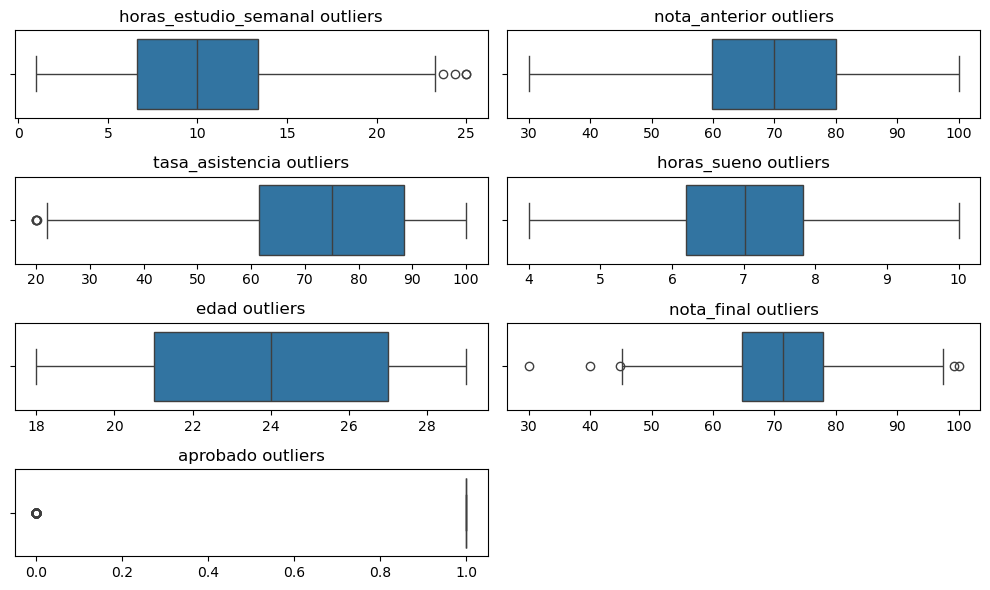

In [7]:
# Visualización de outliers en variables numéricas mediante diagramas de caja

# Seleccionar solo columnas numéricas del DataFrame
df_num = df.select_dtypes(include=np.number)
cols_num = df_num.columns

# Calcular el número de gráficos y filas necesarias
n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2) # Se distribuyen en dos columnas

# Ajustar dinámicamente el tamaño de la figura
width = 5 * 2
height = 1.5 * num_rows
size = (width, height)

# Crear la estructura de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=size)
axes = axes.flat

# Crear un boxplot para cada variable nunmérica
for i, col in enumerate(cols_num):
    sns.boxplot(
        x=col,
        data=df_num,
        ax=axes[i]
    )
    
    axes[i].set_title(f'{col} outliers')
    axes[i].set_xlabel('') # Eliminar etiqueta del eje x para mayor claridad
    
# eliminar el último gráfico si sobra un espacio vacío
if n_plots % 2 != 0:
    fig.delaxes(axes[-1])
    
# Ajustar el layput y mostrar la figura
plt.tight_layout()
plt.show()

que haya outliers no quiere decir que sean datos incorrectos, habría que evaluarlo

en estos datos no parece haber erróneos

## Detección de outliers mediante el método IQR

In [8]:
# Diccionario para almacenar los outliers detectados en cada columna
outliers_dict_iqr = {}

# Iterar sobre cada columna numérica
for col in df_num.columns:
    # Calcular los cuartiles Q1 y Q3
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 -Q1
    
    # Definir los límites para detectar outliers (método de la valla)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los outliers en la columna actual
    outliers = df_num[(df_num[col] < lower_bound) | (df_num[col] > upper_bound)]
    
    # Almacenar los outliers en el diccionario
    outliers_dict_iqr[col] = outliers
    

In [9]:
outliers_dict_iqr['tasa_asistencia'] # vamos revisando cada columna
# dejamos los outliers como están

,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nota_final,aprobado
603,10.207063,60.222635,20.000000,9.574623,19,65.7,1
630,9.072602,60.129355,20.000000,8.063128,29,64.5,1
744,6.209979,76.009529,20.050934,4.809203,23,65.0,1
974,1.000000,30.224020,20.000000,4.339117,23,50.8,0


# Para regresión

La variable objetivo es nota_final

In [10]:
# Hacemos una copia del DataFrame
df_reg = df.copy()

# Seleccionamos la variable objetivo
tv = 'nota_final'

### Codificación

In [11]:
cat_cols = df_reg.select_dtypes(include='O').columns.to_list()
cat_cols

['nivel_dificultad',
 'tiene_tutor',
 'horario_estudio_preferido',
 'estilo_aprendizaje']

Selección de los métodos de codificación

In [12]:
# Utilizamos solo OneHotEncoding ya que hay pocas categorías en todas las columnas
onehot_cols = ['nivel_dificultad', 'tiene_tutor', 'horario_estudio_preferido', 'estilo_aprendizaje']

### OneHotEncoding

In [13]:
# Codificación OneHot
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_reg[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out()
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_reg.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_reg = pd.concat([df_reg.drop(columns=onehot_cols), df_onehot], axis=1)

In [14]:
df_onehot.head()

,nivel_dificultad_Difícil,nivel_dificultad_Fácil,nivel_dificultad_Medio,tiene_tutor_No,tiene_tutor_Sí,horario_estudio_preferido_Mañana,horario_estudio_preferido_Noche,horario_estudio_preferido_Tarde,horario_estudio_preferido_Unknown,estilo_aprendizaje_Auditivo,estilo_aprendizaje_Kinestésico,estilo_aprendizaje_Lectura/Escritura,estilo_aprendizaje_Unknown,estilo_aprendizaje_Visual
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Escalado
#### MinMaxScaler

In [15]:
scaler = MinMaxScaler()
# Muy importante, la variable respuesta nunca se escala
df_reg[df_reg.drop(columns=[tv]).columns] = scaler.fit_transform(df_reg.drop(columns=[tv]))

#### Guardamos el Dataframe procesado

In [16]:
df_reg.to_csv('./datos_transformados/df_regression.csv')

# Para clasificación

#### La variable objetivo es aprobado

In [17]:
# Facemos una copia del DataFrame
df_clas = df.copy()

# Seleccionamos la variable objetivo
tv = 'aprobado'

### Codificación

In [18]:
cat_cols = df_clas.select_dtypes(include='O').columns.to_list()

In [19]:
cat_cols

['nivel_dificultad',
 'tiene_tutor',
 'horario_estudio_preferido',
 'estilo_aprendizaje']

Selección de los métodos de codificación

In [20]:
onehot_cols = ['nivel_dificultad', 'tiene_tutor', 'horario_estudio_preferido', 'estilo_aprendizaje']

#### OneHotEncoding

In [21]:
# Codificación OneHot
onehot_encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_clas[onehot_cols])
onehot_feature_names = onehot_encoder.get_feature_names_out()
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=df_clas.index)

# Concatenar con el DataFrame original y eliminar las columnas originales
df_clas = pd.concat([df_clas.drop(columns=onehot_cols), df_onehot], axis=1)

In [22]:
scaler = MinMaxScaler()
# Muy importante, la variable respuesta nunca se escala
df_clas[df_clas.drop(columns=[tv]).columns] = scaler.fit_transform(df_clas.drop(columns=[tv]))

In [23]:
df_clas.to_csv('./datos_transformados/df_clasification.csv')